In [91]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
import logging
from scipy import fft,signal
import os
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from multiprocessing import Pool
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
import glob
seed=2023

In [92]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[2]-step,step):
        d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
        count +=1
    return d_avg

In [93]:
def get_avg_fr(sp_path,bhv_path,rf_all_b1,cgroup,win,step,in_out="in",e_align="target_on",t_before=200,to_decode='samples',min_n_tr=9):
    # Define target codes 
    position_codes= {
        # code: [ML axis], [plot axis]
        '127': [[10,0],[1,2]],
        '126': [[7,7],[0,2]],
        '125': [[0,10],[0,1]],
        '124': [[-7,7],[0,0]],
        '123': [[-10,0],[1,0]],
        '122': [[-7,-7],[2,0]],
        '121': [[0,-10],[2,1]],
        '120': [[7,-7],[2,2]],
    }
    print(sp_path)
    print(bhv_path)
    data = SpikeData.from_python_hdf5(sp_path)
    # bhv = BhvData.from_python_hdf5(bhv_path)
    s_path = os.path.normpath(sp_path).split(os.sep)
    date = s_path[-1][:19]
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 2))[0]
    # create dict with the trials having each code
    target_codes:Dict[str,list] = defaultdict(list)
    for key in position_codes.keys():
        code_trials = trial_idx[np.any(data.code_numbers[trial_idx] == int(key),axis=1)]
        target_codes['code'] += [key]*len(code_trials)
        target_codes['trial_idx'] += code_trials.tolist()
    target_codes=pd.DataFrame(target_codes)
    if cgroup == 'all':
        neurons = np.where(data.clustersgroup != cgroup)[0]
    else:
        neurons = np.where(data.clustersgroup == cgroup)[0]


    # rf_neurons = rf_all_b1[['date','array_position']][rf_all_b1['date']==date]
    # neurons = neurons[np.in1d(neurons,rf_neurons['array_position'].values)]
    
    if len(neurons) == 0:
        return np.nan,np.nan
    target_codes = target_codes[target_codes['code']!='122']
    trials_neuron = target_codes['trial_idx'].values
    target_codes['trial_idx'] = target_codes['trial_idx'].replace(trials_neuron,np.arange(0,len(trials_neuron)))

        
    sp_avg_all = []
  
    min_task = target_codes.groupby(["code"]).count().min().min()
    # check number of trials
    if min_task>=min_n_tr:
        trials_s_on = data.code_samples[
            trial_idx,
            np.where(data.code_numbers[trial_idx] == task_constants.EVENTS_B2[e_align])[
                1
            ],
        ]
        shifts = -(trials_s_on - t_before).astype(int)
        shifts = shifts[:,np.newaxis]
        shift_sp = SpikeData.indep_roll(data.sp_samples[trial_idx][:,neurons], shifts, axis=2)[:,:, :1400+t_before]
        sp_avg = moving_average(shift_sp, win=win, step=step)
        
    else:
        target_codes = []
        sp_avg=[]
    return target_codes,sp_avg

In [94]:
def sample_df(frs_avg,tasks,min_trials,seed):
    all_df = []
    sample_dict:Dict[str,list] = defaultdict(list)
    
    for i_sample in tasks[0]['code'].unique(): 
        all_sample_fr=[]
        for fr_s,n_task in zip(frs_avg,tasks): #days
            if len(n_task[n_task["code"]==i_sample])==0:
                print(5)
            t_idx = n_task[n_task["code"]==i_sample].sample(min_trials,random_state=seed)["trial_idx"].values
            sample_fr = fr_s[t_idx]
            all_sample_fr.append(sample_fr)
        all_sample_fr = np.concatenate(all_sample_fr,axis=1)
        sample_dict[i_sample] = all_sample_fr
    return sample_dict

In [95]:
def compute_window_matrix(all_df,n_win):
    y,all_samples = [], []
    for i_sample in all_df.keys(): 
        n_df = all_df[i_sample]
        data = n_df[:,:,n_win]

        all_samples.append(data)
        y.append([i_sample]*data.shape[0])
    return np.concatenate(all_samples,axis=0),np.concatenate(y)

In [96]:
def run_svm_decoder(model,frs_avg,tasks,windows,min_trials,it_seed,n_it,le):
    scores = np.zeros((windows))
    all_df= sample_df(frs_avg,tasks,min_trials,it_seed[n_it])
    #all_df['sample']=le.transform(all_df['sample'])
    for n_win in np.arange(0,windows):
        #  select trials randomly
        X,y = compute_window_matrix(all_df,n_win)
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        y=le.transform(y)
        # split in train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,shuffle=True, random_state=it_seed[n_it],stratify=y)
        np.random.seed(it_seed[n_it]) 
        idx_swr = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True, p=None)
        X_train = X_train[idx_swr]
        y_train = y_train[idx_swr]
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        scores[n_win] = metrics.accuracy_score(y_test,y_predict)# cross_val_score(model, X, y, cv=kf,n_jobs=-1).mean()
    return scores

In [97]:
# #TODO: 
# def run_svm_decoder_shift(model,frs_avg,tasks,windows,min_trials,it_seed,n_it,le):
#     scores = np.zeros((windows))
#     all_df= sample_df(frs_avg,tasks,min_trials,it_seed[n_it])
#     #all_df['sample']=le.transform(all_df['sample'])
#     for n_win_train in np.arange(0,windows):
#         X,y = compute_window_matrix(all_df,n_win_train)
#         scaler_train = MinMaxScaler()
#         X = scaler_train.fit_transform(X)
#         y=le.transform(y)

#         for n_win_test in np.arange(0,windows):
#             #  select trials randomly
            

#             # split in train and test
#             X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, np.arange(0,len(X)),test_size=.2,shuffle=True, random_state=it_seed[n_it],stratify=y)
#             np.random.seed(it_seed[n_it]) 
#             idx_swr = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True, p=None)
#             X_train = X_train[idx_swr]
#             y_train = y_train[idx_swr]
#             model.fit(X_train,y_train)
#             y_predict = model.predict(X_test)
#             scores[n_win] = metrics.accuracy_score(y_test,y_predict)
#     return scores

In [98]:
# plot results
def plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron):
    fig,ax = plt.subplots()
    ax.plot(((np.arange(0,len(scores[0]))*win_steps)- neuron_max_shift[n_neuron-1])/1000,scores[:13].mean(axis=0))
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.vlines(
        0, 0.3, 1, color="k", linestyles="dashed"
    )# sample on
    ax.hlines(
        0.5, x_lim_min, x_lim_max, color="gray", linestyles="solid"
    )
    ax.set_title('Is neuron %d engaged in the task?'%(n_neuron))
    ax.set(xlabel="Time (s)", ylabel="SVM classifier accuracy")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['Accuracy','Sample on'], fontsize=9)

### Read and arange data

In [99]:
# Define target codes 
position_codes= {
    # code: [ML axis], [plot axis]
    '127': [[10,0],[1,2]],
    '126': [[7,7],[0,2]],
    '125': [[0,10],[0,1]],
    '124': [[-7,7],[0,0]],
    '123': [[-10,0],[1,0]],
    '122': [[-7,-7],[2,0]],
    '121': [[0,-10],[2,1]],
    '120': [[7,-7],[2,2]],
}

In [100]:
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_bhv_decoding.txt", "r")
lines_bhv = file1.readlines()
file1.close()
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_sp_decoding.txt", "r")
lines_sp = file1.readlines()
file1.close()
directory_b1="/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/detect_rf/lip/b1"
rf_path_b1 = os.path.normpath(str(directory_b1) + "/*.csv")
rf_path_b1 = glob.glob(rf_path_b1, recursive=True)
rf_all = []
for n_path in rf_path_b1:
    rf = pd.read_csv(n_path)
    rf_all.append(rf)
rf_all_b1 = pd.concat(rf_all).reset_index(drop=True)

In [101]:
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())
cgroup = "all"
in_out="in"
e_align="target_on"
win_size = 100
step = 10
fix_duration = 200
sample_duration = 450
fr_samples=[]
max_n_trials = []
num_neurons = 0
to_decode ='samples'
def load_fr_samples(n_bhv:str,n_sp:str,n:int):
    task,sp_avg = get_avg_fr(sp_path=n_sp,bhv_path =n_bhv,rf_all_b1=rf_all_b1,cgroup=cgroup,win=win_size,step=step,in_out=in_out,e_align=e_align,t_before=200,to_decode=to_decode)
    return task,sp_avg
tasks_all,frs_avg_all = [],[]

for n_bhv,n_sp in zip(paths_bhv,paths_sp):
    task,fr_avg = load_fr_samples(n_bhv,n_sp,1)
    if np.any(np.isnan(fr_avg)):
        continue
    tasks_all.append(task)
    frs_avg_all.append(fr_avg)

# with Pool(1) as pool:
#     async_fr = [pool.apply_async(load_fr_samples,args=(paths[n],n)) for n in np.arange(len(paths))] 
#     # frs = [asc.get() for asc in async_fr]
#     for asc in async_fr:
#         tasks_all.append(asc.get()[0])
#         frs_avg_all.append(asc.get()[1])

/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/v4/spikes/2022-11-22_10-59-03_Riesling_v4_e1_r1_sp.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-11-22_10-59-03_Riesling_e1_r1_bhv.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/v4/spikes/2022-11-28_10-23-27_Riesling_v4_e1_r1_sp.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-11-28_10-23-27_Riesling_e1_r1_bhv.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/v4/spikes/2022-12-01_10-23-18_Riesling_v4_e1_r1_sp.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-01_10-23-18_Riesling_e1_r1_bhv.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/v4/spikes/2022-12-01_12-01-59_Riesling_v4_e1_r1_sp.h5
/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-01_12-01-59_Riesling_e1_r1_bhv.h5
/envau/w

In [102]:
# Check the 
tasks,frs_avg = [],[]
for i in range(len(frs_avg_all)):
    if len(frs_avg_all[i]) >0:
        print(i)
        frs_avg.append(np.array(frs_avg_all[i]))
        tasks.append(tasks_all[i])

4
15


In [103]:
frs_avg[0].shape

(80, 79, 160)

In [104]:
# max number of trials that can be used 
min_trials = frs_avg[0].shape[0]
for rec in range(len(tasks)):
    min_n_trials = tasks[rec].groupby(["code"]).count().min()[0]
    print(min_n_trials, rec)
    min_trials = min_n_trials if min_n_trials < min_trials else min_trials

9 0
9 1


In [105]:
min_trials

9

### Define and use SVM for decoding

In [106]:
model=  SVC(kernel='linear',C=1,decision_function_shape='ovr',gamma='auto',degree=1)

In [107]:
# le = LabelEncoder()

# le.fit(tasks[0]['sample'].unique())
# all_df= sample_df(frs_avg,tasks,min_trials,1235)
# X,y = compute_window_matrix(all_df,75)
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
# y=le.transform(y)
# from sklearn.model_selection import GridSearchCV
# parameters = {'C': [1, 10,100,20,1000],'degree':[2,3,4,5],'gamma':[1,0.1,0.001,0.0001,'scale','auto'], 'kernel': ['linear','poly'],'decision_function_shape':['ovr']}
# clf = GridSearchCV(SVC(), parameters)
# clf.fit(X, y)
# clf.best_params_

In [108]:
tasks[0]

,code,trial_idx
0,127,0
1,127,1
2,127,2
3,127,3
4,127,4
...,...,...
75,120,75
76,120,76
77,120,77
78,120,78


In [109]:
le = LabelEncoder()

le.fit(tasks[0]['code'].unique())
#all_df['sample']=le.transform(all_df['sample'])
n_iterations = 100
rng = np.random.default_rng(seed=seed)
it_seed = rng.integers(low=1, high=2023, size=n_iterations, dtype=int)
windows = frs_avg[0].shape[2]
scores=[]
for n_it in range(n_iterations):
    scores.append(run_svm_decoder(model,frs_avg,tasks,windows,min_trials,it_seed,n_it=n_it,le=le))

# with Pool(5) as pool:
#     async_scores = [pool.apply_async(run_svm_decoder,args=(model,frs_avg,tasks,windows,min_trials,it_seed,n,le)) for n in np.arange(n_iterations)] 
#     scores = [asc.get() for asc in async_scores]

In [110]:
min_n_trials

9

In [111]:
n_neurons = 0
for rec in range(len(frs_avg)):
    n_neurons +=frs_avg[rec].shape[1]

In [112]:
n_neurons

114

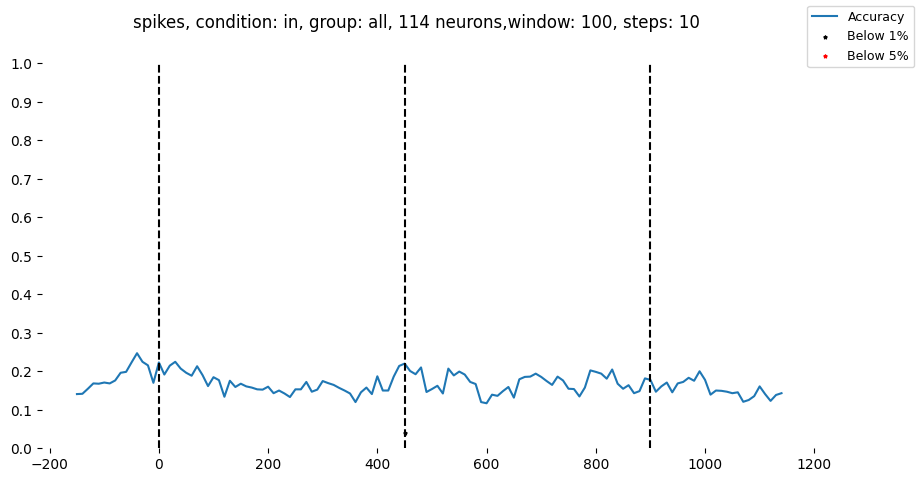

In [116]:
scores2 = np.array(scores)[:,:130]
s_path = os.path.normpath(paths_sp[0]).split(os.sep)
fig,ax = plt.subplots(figsize=(10,5))
x = ((np.arange(0, len(scores2[0]))) - (fix_duration-50) / step) * 10
ax.plot(x, np.array(scores2).mean(axis=0), label="Accuracy")
threshole = 0.14
ss = np.sum(np.array(scores2) <= threshole, axis=0) / np.array(scores2).shape[0]
mask_inf = ss <= 0.1
mask_inf_5 = ss <= 0.05
# stars
ax.scatter(
    x[mask_inf],
    [threshole - 0.1] * len(x[mask_inf]),
    color="k",
    marker="*",
    label="Below 1%",
    s=6,
)
ax.scatter(
    x[mask_inf_5],
    [threshole - 0.12] * len(x[mask_inf_5]),
    color="r",
    marker="*",
    label="Below 5%",
    s=6,
)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
# delete boundaries
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
fig.legend(fontsize=9)
fig.suptitle(
    "%s, condition: %s, group: %s, %d neurons,window: %d, steps: %d"
    % (s_path[-2], in_out, cgroup, n_neurons, win_size, step)
)
ax.vlines([0,450,900],0,1,'k','--')

In [114]:
#np.save('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_orient_c1_gauto.npy', arr=scores)

In [115]:
# fig.savefig('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/pfc_samples_1000it_all_in_win100.jpg', format='jpg')